In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import gzip
import os
import pickle
import platform

import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.misc import imread

from common import * 
import preprocess
import model_io

Using TensorFlow backend.


# Base Model

The full inception model is too slow for real time use on my laptop, so I am just using the first few layers.

Loading the whole inception model is also very slow, so cut out only the weights we need and save them for loading later.

In [3]:
import inception
import model_io

CUT_INDEX=44

if not os.path.exists(base_model_stem(CUT_INDEX) + '.json'):
    model_io.save_model(
        base_model_stem(CUT_INDEX) + '.json',
        base_model_stem(CUT_INDEX) + '.h5',
        inception.make_cut_model(CUT_INDEX))

In [ ]:
model_io.load_base_model(CUT_INDEX).summary()

# Preprocessing

- Correct the image file paths, since I have several driving logs in different folders.
- Smooth the control inputs. The input from me is quite spikey, because all I can do is press a button or not. This seems like it would make learning quite difficult, so apply smoothing.
- Bottleneck the features to make training reasonably fast.

In [4]:
log = pd.concat([
#     preprocess.run('data/ccw_1', CUT_INDEX),
#     preprocess.run('data/cw_1', CUT_INDEX),
    preprocess.run('data/ccw_2', CUT_INDEX),
    preprocess.run('data/cw_2', CUT_INDEX),
    preprocess.run('data/ccw_recover_from_right_1', CUT_INDEX),
    preprocess.run('data/ccw_recover_from_left_1', CUT_INDEX),
    preprocess.run('data/cw_recover_from_right_1', CUT_INDEX),
    preprocess.run('data/cw_recover_from_left_1', CUT_INDEX),
    preprocess.run('data/ccw_turnout_1', CUT_INDEX),
    preprocess.run('data/ccw_turnout_2', CUT_INDEX)
])
print(log.head())

data/ccw_2/bottleneck_44 exists; just binding.
data/cw_2/bottleneck_44 exists; just binding.
data/ccw_recover_from_right_1/bottleneck_44 exists; just binding.
data/ccw_recover_from_left_1/bottleneck_44 exists; just binding.
data/cw_recover_from_right_1/bottleneck_44 exists; just binding.
data/cw_recover_from_left_1/bottleneck_44 exists; just binding.
data/ccw_turnout_1/bottleneck_44 exists; just binding.
index 0
index 50
index 100
index 150
index 200
index 250
index 300
index 350
index 400
index 450
index 500
                                        center_image  \
0  data/ccw_2/IMG/center_2016_12_10_17_02_46_943.jpg   
1  data/ccw_2/IMG/center_2016_12_10_17_02_47_043.jpg   
2  data/ccw_2/IMG/center_2016_12_10_17_02_47_143.jpg   
3  data/ccw_2/IMG/center_2016_12_10_17_02_47_259.jpg   
4  data/ccw_2/IMG/center_2016_12_10_17_02_47_360.jpg   

                                        left_image  \
0  data/ccw_2/IMG/left_2016_12_10_17_02_46_943.jpg   
1  data/ccw_2/IMG/left_2016_12_10_17_02_

## Dataset Summary


In [5]:
def summarize_dataset():
    groups = log.groupby('dataset')
    totals = groups['center_image'].agg([len])
    mean_speed = groups['speed'].mean()
    mean_steering_angle = groups['steering_angle'].mean()
    return pd.concat([totals, mean_speed, mean_steering_angle], axis=1)
summarize_dataset()

,len,speed,steering_angle
dataset,,,
ccw_2,2882,8.833225,-0.041838
ccw_recover_from_left_1,1405,11.775736,0.050748
ccw_recover_from_right_1,1361,10.212416,-0.123761
ccw_turnout_1,713,9.905384,-0.085719
ccw_turnout_2,522,9.295456,-0.111309
cw_2,2391,9.972545,0.036800
cw_recover_from_left_1,1550,10.484323,0.128920
cw_recover_from_right_1,1721,8.972610,0.017962


## Smoothing

I tried two types of smoothing:

- Exponential smoothing: an exponential weighted moving average
- Gaussian smoothing: a 1D gaussian filter

Both seem to track pretty well, but the gaussian smoothing is better at preserving the mean steering angle.

In [ ]:
def plot_smooth_steering_angle():
    df = log[['time', 'steering_angle', 'smooth_steering_angle_1', 'smooth_steering_angle_gaussian_3']]
    df = df[:600]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_smooth_steering_angle()

## Steering Angle Bias

We don't want a lot of bias in the training data. Or maybe this isn't that important... I don't really know.

In [ ]:
print('raw steering angle bias:', np.mean(log['steering_angle']))
print('exponentially smoothed steering angle bias:', np.mean(log['smooth_steering_angle_1']))
print('gaussian smoothed steering angle bias:', np.mean(log['smooth_steering_angle_gaussian_5']))

## Bottleneck Features

In [ ]:
def plot_bottleneck_output(num_images, num_channels, image_stride=100):
    fig, axes = plt.subplots(num_images, num_channels,
                             figsize=(2*num_channels, 2*num_images),
                             sharex=True, sharey=True)
    for i in range(num_images):
        index = i * image_stride
        image = np.load(log['bottleneck_features'].values[index])['center_image']
        for j in range(num_channels):
            axes[i][j].imshow(image[:,:,j], cmap='gray')
plot_bottleneck_output(3,5)

## Smoothed Steering Video

In [21]:
def steering_angle_to_radians(steering_angle):
    """
    The recorded steering angle ranges from -1 to 1.
    In the sim, it gives values from -25 degrees to 25 degrees.
    """
    return math.radians(steering_angle * 25.0)

def draw_steering_angle(image, steering_angle, color, thickness=2):
    bottom_x = image.shape[1] / 2.0
    bottom_y = image.shape[0]
    radius = bottom_y / 2.0
    steering_angle_radians = steering_angle_to_radians(steering_angle)
    top_x = bottom_x + radius * math.sin(steering_angle_radians)
    top_y = bottom_y - radius * math.cos(steering_angle_radians)
    bottom_x, bottom_y = int(round(bottom_x)), int(round(bottom_y))
    top_x, top_y = int(round(top_x)), int(round(top_y))
    cv2.line(image, (bottom_x, bottom_y), (top_x, top_y), color, thickness)

def make_steering_movie(
    filestem,
    log,
    smoothed_steering_angle_column,
    predicted_steering_angle_column=None):
    
    if platform.system() == 'Linux':
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        filename = filestem + '.avi'
    else:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')        
        filename = filestem + '.mp4'
    
    input_color = [0, 0, 255]
    smoothed_color = [0, 255, 0]
    predicted_color = [255, 0, 0]
    video = cv2.VideoWriter(filename, fourcc, 10, IMAGE_SHAPE[0:2][::-1])
    for i in range(len(log)):
        if i % 50 == 0:
            print('frame', i)
        image = imread(log['center_image'].values[i])
        steering_angle = log['steering_angle'].values[i]
        draw_steering_angle(image, steering_angle, input_color)

        smoothed_steering_angle = log[smoothed_steering_angle_column].values[i]
        draw_steering_angle(image, smoothed_steering_angle, smoothed_color)
        
        if predicted_steering_angle_column is not None:
            predicted_steering_angle = log[predicted_steering_angle_column].values[i]
            draw_steering_angle(image, predicted_steering_angle, predicted_color)

        cv2.putText(image, log['center_image'].values[i],
                    (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.1, 0)
            
        video.write(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    video.release()
    
for dataset in log['dataset'].unique():
    make_steering_movie(os.path.join('data', dataset, 'check'),
                        log[log['dataset'] == dataset][0:100],
                        'smooth_steering_angle_1')
    break

frame 0
frame 50


# Model

- I put a 1x1 convolution up front to reduce the depth, in order to make the model a more manageable size.

## Experiments with Unsmoothed Steering Angles

- Tried just adding a linear model (32--128 units, L2 regularization with weights 0.001--0.01) after the 1x1 convolution, but validation loss generally bottomed out at about MSE 0.04, which is too high. It also tended to diverge, at least with the Adam optimizer.
- Tried adding a hidden layer (32-128 units) with ReLU activation and dropout before the linear layer, but that seemed to just predict a small constant steering angle most of the time. Maybe a "dying relus" problem. It seems you can get an MSE around 0.05 by just predicting a constant near zero all the time.
- So I tried tanh activation instead, but that did not seem to help.
- I switched back to L2 regularization with ReLUs, which did a bit better but still understeered.
- I think the problem is that it's too easy to just ignore my occasional steering inputs (key presses).

## Experiments with Smoothed Steering Angles

- Tried the linear model again. No longer predicting constants, but it starts overfitting (increase in validation loss) after only a couple of epochs. Probably going to need something more expressive.
- Tried adding hidden layer (32 units) with ReLU activation and L2 regularization (weight 0.01). Still mostly predicting a small constant.
- Tried tanh activation on the hidden layer. Now it seems much happier: getting to the bridge and MSE 0.015 with nb_filter=64, nb_hidden=32 and l2_weight=0.01. Still understeering a bit on gentler bends.
- Tried reducing L2 weight to 0.005. That seemed to slow down training quite a lot; got to MSE 0.017 after 16 epochs. Still understeering and weaving a bit.
- Tried mean absolute error instead of mean squared error, since all of the errors are actually pretty small. New record on first run: made it to the turnout but didn't turn left. MAE 0.0611. Some weaving, but much less understeer. Much better fit in the steering prediction plot; good to see that better fit corresponds to better performance in this case. Adam optimizer diverged after 3 epochs, however.
- Tried increasing regularization back to 0.01. That seems to make it get stuck on a constant again.
- Tried putting regularization back to 0.005 but using Adagrad instead of Adam. Still getting stuck. Subsequent runs with Adam also getting stuck. Looks like I just got lucky that first time.
- Then I tried shrinking the initialization weights (using a normal distribution with scale 0.1). Since doing that, I've had much better luck with convergence.

Hall of fame:
- models/grid_model_nb_hidden-32label_column-smooth_steering_angle_gaussian_3l2_weight-0.001nb_epoch-30batch_size-128nb_filter-64side_camera_bias-optimizer-adagradversion-4.json
- ok_64_32_0.01maybe_1.0bias

In [6]:
import batch

In [12]:
batch_params = {
    'test_size': 0.2,
    'random_state': 42,
    'batch_size': 128,
    'label_column': 'smooth_steering_angle_gaussian_3',
    'side_camera_bias': 1.5/25
}
nb_train, batch_files_train, nb_val, batch_files_val = \
batch.make_train_val_batches(log, batch_params)

batches/batch.batch_size-128.label_column-smooth_steering_angle_gaussian_3.random_state-42.side_camera_bias-0.06.test_size-0.2 for batches exists


In [13]:
import model

In [ ]:
steering_model = model.build(
    input_shape=np.load(log['bottleneck_features'].values[0])['center_image'].shape,
    nb_filter=64,
    nb_hidden=32,
    l2_weight=0.01,
    optimizer='adam'
)

history = model.train(
    steering_model,
    nb_epoch=20,
    patience=2,
    nb_train=nb_train,
    batch_files_train=batch_files_train,
    nb_val=nb_val,
    batch_files_val=batch_files_val,
    save_stem='model')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_2 (Convolution2D)  (None, 17, 37, 64)    16448       convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 40256)         0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 32)            1288224     flatten_2[0][0]                  
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 1)             33          dense_3[0][0]                    
Total params: 1304705
_____________________________________________________________________

In [19]:
# load model with best validation loss
steering_model = model_io.load_model('model.json', 'model.h5')

In [21]:
def make_prefix_prediction(end):
    df = log[:600].copy()
    df['predicted_steering_angle'] = steering_model.predict_on_batch(
        batch.make_batch(
            df,
            label_column=batch_params['label_column'],
            side_camera_bias=None)[0])
    return df
log_prefix_with_prediction = make_prefix_prediction(600)

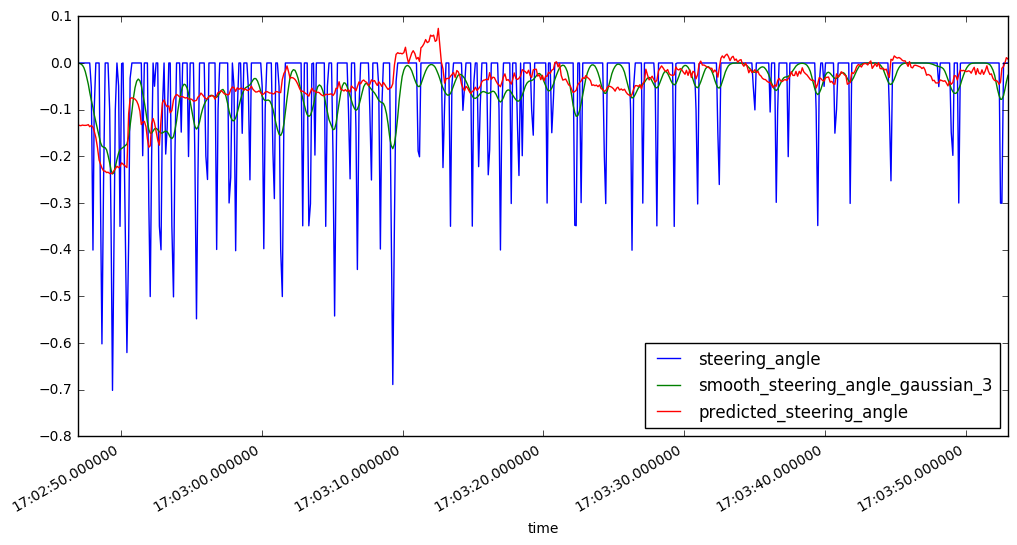

In [22]:
def plot_predicted_steering_angle():
    df = log_prefix_with_prediction[
        ['time', 'steering_angle', batch_params['label_column'], 'predicted_steering_angle']]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_predicted_steering_angle()

In [22]:
make_steering_movie('test', log_prefix_with_prediction, batch_params['label_column'], 'predicted_steering_angle')

frame 0
frame 50
frame 100
frame 150
frame 200
frame 250
frame 300
frame 350
frame 400
frame 450
frame 500
frame 550


In [ ]:
import itertools

# From http://stackoverflow.com/a/40623158/2053820
def dict_product(dicts):
    """
    >>> list(dict_product(dict(number=[1,2], character='ab')))
    [{'character': 'a', 'number': 1},
     {'character': 'a', 'number': 2},
     {'character': 'b', 'number': 1},
     {'character': 'b', 'number': 2}]
    """
    return (dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))

def make_model_key_stem(key):
    stem = os.path.join('models', 'grid_model_')
    for param, value in key.items():
        if value is None: value = ''
        stem += param + '-' + str(value)
    return stem

In [ ]:
def search():
    results_file = 'grid.pickle'
    if os.path.isfile(results_file):
        with open(results_file, 'rb') as f:
            results = pickle.load(f)
    else:
        results = {}
    
    keys = {
        'version': [2,3,4],
        'nb_epoch': [30],
        'side_camera_bias': [None],
        'label_column': ['smooth_steering_angle_gaussian_3'],
        'batch_size': [128],
        'nb_filter': [64, 128],
        'nb_hidden': [64, 32],
        'l2_weight': [0.001, 0.005, 0.01],
        'optimizer': ['adam', 'adagrad']
    }
    
    input_shape = np.load(log['bottleneck_features'].values[0])['center_image'].shape
        
    for key in dict_product(keys):
        print(key)
        frozen_key = frozenset(key.items())
        if frozen_key in results:
            continue
        print('Running...')
        
        key_stem = make_model_key_stem(key)
        model_json = key_stem + '.json'
        model_weights_h5 = key_stem + '.h5'
        
        key = key.copy()
        del key['version']
        
        steering_model = model.build(
            input_shape,
            nb_filter=key.pop('nb_filter'),
            nb_hidden=key.pop('nb_hidden'),
            l2_weight=key.pop('l2_weight'),
            optimizer=key.pop('optimizer'))
        
        history = model.train(
            steering_model,
            log,
            label_column=key.pop('label_column'),
            test_size=0.2,
            nb_epoch=key.pop('nb_epoch'),
            batch_size=key.pop('batch_size'),
            side_camera_bias=key.pop('side_camera_bias'),
            save_stem=key_stem)
        
        steering_model.load_weights(model_weights_h5) # best weights
        
        model_io.save_model(model_json, model_weights_h5, steering_model)
                    
        results[frozen_key] = {
            'history': history.history,
            'model_json': model_json,
            'model_weights_h5': model_weights_h5
        }
        
        with open(results_file, 'wb') as f:
            pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

    return results  

grid = search()

TODO

- there is a wiggle in ccw_recover_from_left_1 at about 0:42

In [ ]:
def summarize_grid(grid, val_loss_threshold):
    """
    Print out the more promising hyperparameters from a search, according to
    validation loss.
    """
    best_val_loss = 1e9
    best_params = None
    items = sorted(grid, key = lambda k: min(grid[k]['history']['val_loss']))
    for frozen_key in items:
        value = grid[frozen_key]
        key = dict(frozen_key)
        val_loss = value['history']['val_loss']
        min_val_loss = min(val_loss)
        nb_epochs = len(val_loss)
        if min_val_loss < val_loss_threshold:
            print(key, min_val_loss, nb_epochs)
            print('cp', value['model_json'], 'model.json')
            print('cp', value['model_weights_h5'], 'model.h5')
            print('python drive.py model.json')
            print()
        if min_val_loss < best_val_loss:
            best_val_loss = min_val_loss
            best_params = key
    print('BEST:', best_params, best_val_loss)
summarize_grid(grid, 0.005)

In [ ]:
results_file = 'grid.pickle'
if os.path.isfile(results_file):
    with open(results_file, 'rb') as f:
        grid = pickle.load(f)


In [ ]:
import batch